# 1. Вводная часть

## Повышение разрешения изображений с помощью автокодировщиков с глубокими сверточными сетями

## Сравнение Autoencoder vs. Bicubic Interpolation

* **Автор:** Лебедев И.Н.
* **GitHub:** ([ссылка](https://github.com/awessine))   
* **Telegram:** ([ссылка](https://t.me/zlaya_p4ola))

---

### Аннотация

В данной работе исследуется применение автокодировщиков с глубокими сверточными сетями для задачи повышения разрешения изображений (Super-Resolution). Основная цель - сравнить эффективность нейросетевого подхода с традиционным методом бикубической интерполяции.

# 2. Установка и импорт библиотек

In [ ]:
# Установка необходимых библиотек
!pip install tensorflow
!pip install scikit-image
!pip install matplotlib
!pip install numpy
!pip install opencv-python
!pip install Pillow

In [ ]:
# Импорт основных библиотек
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import VGG19

import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import os
import random
from sklearn.model_selection import train_test_split

# Настройка для воспроизводимости результатов
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

print("TensorFlow версия:", tf.__version__)
print("GPU доступен:", tf.config.list_physical_devices('GPU'))

TensorFlow версия: 2.18.0
GPU доступен: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 3. Теоретическая часть

## 3.1 Проблема повышения разрешения изображений

**Super-Resolution (SR)** - это задача восстановления изображения высокого разрешения из изображения низкого разрешения. Эта проблема является обратной и плохо поставленной, поскольку для одного изображения низкого разрешения может существовать множество соответствующих изображений высокого разрешения.

Математически задачу можно сформулировать как:
$$I_{LR} = D(I_{HR})$$

где:
- $I_{LR}$ - изображение низкого разрешения
- $I_{HR}$ - изображение высокого разрешения  
- $D$ - оператор деградации (обычно включает размытие и субдискретизацию)

Цель SR - найти обратное отображение $D^{-1}$.

## 3.2 Традиционные методы интерполяции

**Бикубическая интерполяция** - один из наиболее популярных традиционных методов. Она использует 16 ближайших пикселей для вычисления нового значения:

$$p(x,y) = \sum_{i=0}^{3} \sum_{j=0}^{3} a_{ij} x^i y^j$$

Преимущества:
- Быстрая вычислимость
- Не требует обучения
- Гладкие результаты

Недостатки:
- Чрезмерное сглаживание
- Потеря высокочастотных деталей
- Ограниченное качество восстановления

## 3.3 Автокодировщики для Super-Resolution

**Автокодировщик** - это нейронная сеть, состоящая из двух частей:
- **Энкодер**: сжимает входные данные в латентное представление
- **Декодер**: восстанавливает данные из латентного представления

Для задачи SR архитектура модифицируется:
- Вход: изображение низкого разрешения
- Выход: изображение высокого разрешения

**Функция потерь** обычно включает:
$$\mathcal{L} = \mathcal{L}_{MSE} + \lambda \mathcal{L}_{perceptual}$$

где:
- $\mathcal{L}_{MSE}$ - среднеквадратичная ошибка
- $\mathcal{L}_{perceptual}$ - перцептуальная потеря на основе VGG

## 3.4 Архитектура модели

Наша модель будет использовать следующие компоненты:

1. **Сверточные слои** для извлечения признаков
2. **Остаточные блоки** для глубокого обучения
3. **Слои повышения размерности** (Upsampling/Transpose Convolution)
4. **Skip connections** для сохранения деталей

```
Input (32x32x3) → Conv2D → ResBlocks → Upsampling → Output (128x128x3)
```

Коэффициент увеличения: 4x (32×32 → 128×128)

## 3.5 Метрики качества

Для оценки качества восстановления используются:

**PSNR (Peak Signal-to-Noise Ratio):**
$$PSNR = 10 \log_{10} \frac{MAX^2}{MSE}$$

**SSIM (Structural Similarity Index):**
$$SSIM(x,y) = \frac{(2\mu_x\mu_y + c_1)(2\sigma_{xy} + c_2)}{(\mu_x^2 + \mu_y^2 + c_1)(\sigma_x^2 + \sigma_y^2 + c_2)}$$

- PSNR измеряет отношение сигнал/шум (выше = лучше)
- SSIM оценивает структурное сходство (0-1, выше = лучше)

# 4. Подготовка данных

## 4.1 Загрузка датасета и формирование выборки

In [ ]:
# Загрузка и подготовка данных
# Используем встроенный датасет CIFAR-10

(x_train_full, _), (x_test_full, _) = tf.keras.datasets.cifar10.load_data()

# Нормализация данных
x_train_full = x_train_full.astype('float32') / 255.0
x_test_full = x_test_full.astype('float32') / 255.0

# Используем очень малую выборку для демонстрации
train_size = 5000
test_size = 1000

# Берем случайные индексы для разнообразия
train_indices = np.random.choice(len(x_train_full), train_size, replace=False)
test_indices = np.random.choice(len(x_test_full), test_size, replace=False)

x_train_subset = x_train_full[train_indices]
x_test_subset = x_test_full[test_indices]

print(f"Размер обучающей выборки: {x_train_subset.shape}")
print(f"Размер тестовой выборки: {x_test_subset.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Размер обучающей выборки: (5000, 32, 32, 3)
Размер тестовой выборки: (1000, 32, 32, 3)


In [ ]:
# Очищаем память от полных датасетов
del x_train_full, x_test_full

## 4.2 Предобработка

In [ ]:
# Функция для создания одной пары LR-HR изображений
def create_single_lr_hr_pair(img, scale_factor=4, target_size=(128, 128)):  # Уменьшили размер
    """
    Создает одну пару изображений низкого и высокого разрешения
    """
    # Увеличиваем до высокого разрешения
    hr_img = cv2.resize(img, target_size, interpolation=cv2.INTER_CUBIC)
    # Создаем версию низкого разрешения
    low_size = (target_size[0] // scale_factor, target_size[1] // scale_factor)
    lr_img = cv2.resize(hr_img, low_size, interpolation=cv2.INTER_AREA)
    return lr_img, hr_img

In [ ]:
# Генератор данных для экономии памяти
class SuperResolutionDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, original_images, batch_size=16, scale_factor=4,
                 target_size=(128, 128), shuffle=True):
        self.original_images = original_images
        self.batch_size = batch_size
        self.scale_factor = scale_factor
        self.target_size = target_size
        self.shuffle = shuffle
        self.indices = np.arange(len(original_images))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return len(self.original_images) // self.batch_size

    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        end_idx = start_idx + self.batch_size
        batch_indices = self.indices[start_idx:end_idx]

        lr_batch = []
        hr_batch = []

        for i in batch_indices:
            lr_img, hr_img = create_single_lr_hr_pair(
                self.original_images[i],
                self.scale_factor,
                self.target_size
            )
            lr_batch.append(lr_img)
            hr_batch.append(hr_img)

        return np.array(lr_batch), np.array(hr_batch)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

## 4.3 Визуализация данных

In [ ]:
# Создаем несколько примеров для визуализации (не храним все в памяти)
sample_lr = []
sample_hr = []
for i in range(4):  # Только для демонстрации
    lr_img, hr_img = create_single_lr_hr_pair(x_train_subset[i])
    sample_lr.append(lr_img)
    sample_hr.append(hr_img)

sample_lr = np.array(sample_lr)
sample_hr = np.array(sample_hr)

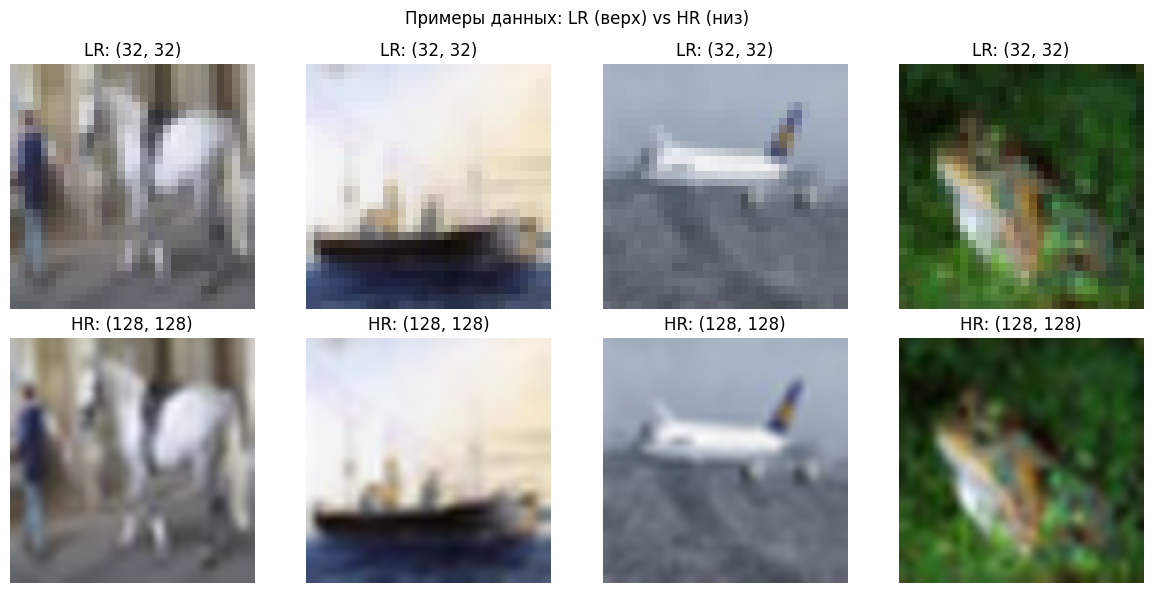

In [ ]:
def visualize_data_samples(lr_images, hr_images, n_samples=4):
    """
    Визуализирует примеры изображений низкого и высокого разрешения
    """
    fig, axes = plt.subplots(2, n_samples, figsize=(12, 6))
    for i in range(n_samples):
        # Изображения низкого разрешения
        axes[0, i].imshow(lr_images[i])
        axes[0, i].set_title(f'LR: {lr_images[i].shape[:2]}')
        axes[0, i].axis('off')
        # Изображения высокого разрешения
        axes[1, i].imshow(hr_images[i])
        axes[1, i].set_title(f'HR: {hr_images[i].shape[:2]}')
        axes[1, i].axis('off')
    plt.suptitle('Примеры данных: LR (верх) vs HR (низ)')
    plt.tight_layout()
    plt.show()

visualize_data_samples(sample_lr, sample_hr)

In [ ]:
# Очищаем примеры из памяти
del sample_lr, sample_hr

## 4.4 Разделение выборки

In [ ]:
# Разделение на train/validation
train_split = int(0.8 * len(x_train_subset))
val_split = len(x_train_subset) - train_split

# Создаем индексы для разделения
train_indices = np.arange(train_split)
val_indices = np.arange(train_split, len(x_train_subset))

# Создаем генераторы данных
train_generator = SuperResolutionDataGenerator(
    x_train_subset[train_indices],
    batch_size=8,  # Уменьшили batch_size для экономии памяти
    shuffle=True
)

val_generator = SuperResolutionDataGenerator(
    x_train_subset[val_indices],
    batch_size=8,
    shuffle=False  # Для валидации не нужно перемешивать
)

test_generator = SuperResolutionDataGenerator(
    x_test_subset,
    batch_size=8,
    shuffle=False
)

print(f"Обучающих батчей: {len(train_generator)}")
print(f"Валидационных батчей: {len(val_generator)}")
print(f"Тестовых батчей: {len(test_generator)}")


Обучающих батчей: 500
Валидационных батчей: 125
Тестовых батчей: 125


In [ ]:
# Тестируем генератор
sample_lr_batch, sample_hr_batch = train_generator[0]
print(f"Размер LR батча: {sample_lr_batch.shape}")
print(f"Размер HR батча: {sample_hr_batch.shape}")
print(f"Диапазон значений LR: [{sample_lr_batch.min():.3f}, {sample_lr_batch.max():.3f}]")
print(f"Диапазон значений HR: [{sample_hr_batch.min():.3f}, {sample_hr_batch.max():.3f}]")

# Очищаем тестовый батч
del sample_lr_batch, sample_hr_batch

Размер LR батча: (8, 32, 32, 3)
Размер HR батча: (8, 128, 128, 3)
Диапазон значений LR: [-0.000, 1.002]
Диапазон значений HR: [-0.035, 1.061]


# 5. Реализация модели

## 5.1 Определение архитектуры

In [ ]:
# Остаточный блок
def residual_block(x, filters=64):
    """
    Остаточный блок для сохранения градиентов и улучшения обучения
    """
    shortcut = x

    # Если количество каналов не совпадает, подгоняем shortcut
    if x.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, padding='same')(shortcut)

    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Add()([shortcut, x])
    x = layers.ReLU()(x)

    return x

# Блок увеличения разрешения
def upsampling_block(x, filters=64, scale=2):
    """
    Блок для увеличения пространственного разрешения
    """
    x = layers.Conv2D(filters * (scale ** 2), 3, padding='same')(x)

    class PixelShuffle(layers.Layer):
      def __init__(self, scale=2, **kwargs):
          super(PixelShuffle, self).__init__(**kwargs)
          self.scale = scale

      def call(self, x):
          return tf.nn.depth_to_space(x, self.scale)

      def get_config(self):
          config = super().get_config()
          config.update({"scale": self.scale})
          return config

    x = PixelShuffle(scale)(x)
    x = layers.ReLU()(x)

    return x

In [ ]:
# Создание модели автокодировщика для Super-Resolution
def create_sr_autoencoder(input_shape=(32, 32, 3), scale_factor=4):
    """
    Создает автокодировщик для повышения разрешения изображений
    """
    inputs = layers.Input(shape=input_shape)

    # Начальная обработка
    x = layers.Conv2D(64, 9, padding='same')(inputs)
    x = layers.LeakyReLU(0.2)(x)  # Используем LeakyReLU

    # Остаточные блоки
    for _ in range(4):
        x = residual_block(x, 64)

    # Блоки увеличения разрешения
    x = upsampling_block(x, 64, 2)
    x = upsampling_block(x, 32, 2)  # Уменьшаем фильтры

    # Финальный слой - ВАЖНО: убираем батч-норм перед выходом
    x = layers.Conv2D(16, 3, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)

    # Выходной слой с tanh, затем нормализация
    outputs = layers.Conv2D(3, 9, padding='same', activation='tanh')(x)
    outputs = layers.Lambda(lambda x: (x + 1.0) / 2.0)(outputs)  # [-1,1] -> [0,1]

    model = models.Model(inputs, outputs, name='SR_Autoencoder')
    return model

# Создание модели
sr_model = create_sr_autoencoder()
sr_model.summary()

Model: "SR_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     15,616 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     36,928 │ leaky_re_lu_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ leaky_re_lu_1[0]… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 32, 32,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 32,    │          0 │ re_lu[0][0],      │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 32, 32,    │          0 │ add_1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_6[0][0]  

 Total params: 543,171 (2.07 MB)

 Trainable params: 542,147 (2.07 MB)

 Non-trainable params: 1,024 (4.00 KB)

## 5.2 Функции потерь и метрики

In [ ]:
# Определение функций потерь и метрик
def perceptual_loss_simple(y_true, y_pred):
    """
    Упрощенная перцептуальная потеря для экономии памяти
    """
    # Используем градиенты изображения для перцептуальной потери
    def image_gradients(img):
        # Вычисляем градиенты по x и y
        sobel_x = tf.image.sobel_edges(img)[:, :, :, :, 0]
        sobel_y = tf.image.sobel_edges(img)[:, :, :, :, 1]
        return tf.concat([sobel_x, sobel_y], axis=-1)

    true_gradients = image_gradients(y_true)
    pred_gradients = image_gradients(y_pred)

    return tf.reduce_mean(tf.square(true_gradients - pred_gradients))

def combined_loss_simple(y_true, y_pred):
    """
    Упрощенная комбинированная потеря: MSE + градиентная потеря
    """
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    grad_loss = perceptual_loss_simple(y_true, y_pred)

    return mse_loss + 0.1 * grad_loss  # Весовой коэффициент для перцептуальной потери

# Компиляция модели
sr_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='mse',
    metrics=['mae']
)

# 6. Обучение модели

## 6.1 Процесс обучения

In [ ]:
# Настройка callbacks для обучения
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7
    ),
    keras.callbacks.ModelCheckpoint(
        'best_sr_model.weights.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True
    )
]

In [ ]:
# Обучение модели
history = sr_model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

print("\nОбучение завершено!")

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.0239 - mae: 0.1099 - val_loss: 0.0091 - val_mae: 0.0784 - learning_rate: 1.0000e-04
Epoch 2/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.0058 - mae: 0.0595 - val_loss: 0.0031 - val_mae: 0.0411 - learning_rate: 1.0000e-04
Epoch 3/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.0039 - mae: 0.0489 - val_loss: 0.0031 - val_mae: 0.0435 - learning_rate: 1.0000e-04
Epoch 4/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.0027 - mae: 0.0405 - val_loss: 0.0020 - val_mae: 0.0339 - learning_rate: 1.0000e-04
Epoch 5/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.0024 - mae: 0.0377 - val_loss: 0.0016 - val_mae: 0.0308 - learning_rate: 1.0000e-04
Epoch 6/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0020 - mae: 0.0345 - val_loss: 0.0014 - val_mae: 0.0288 - learning_rate: 1.0000e-04
Epoch 7/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.0016 - mae: 0.0304 - val_loss: 0.0026 - val_mae: 0.0398 - l

## 6.2 Визуализация процесса обучения

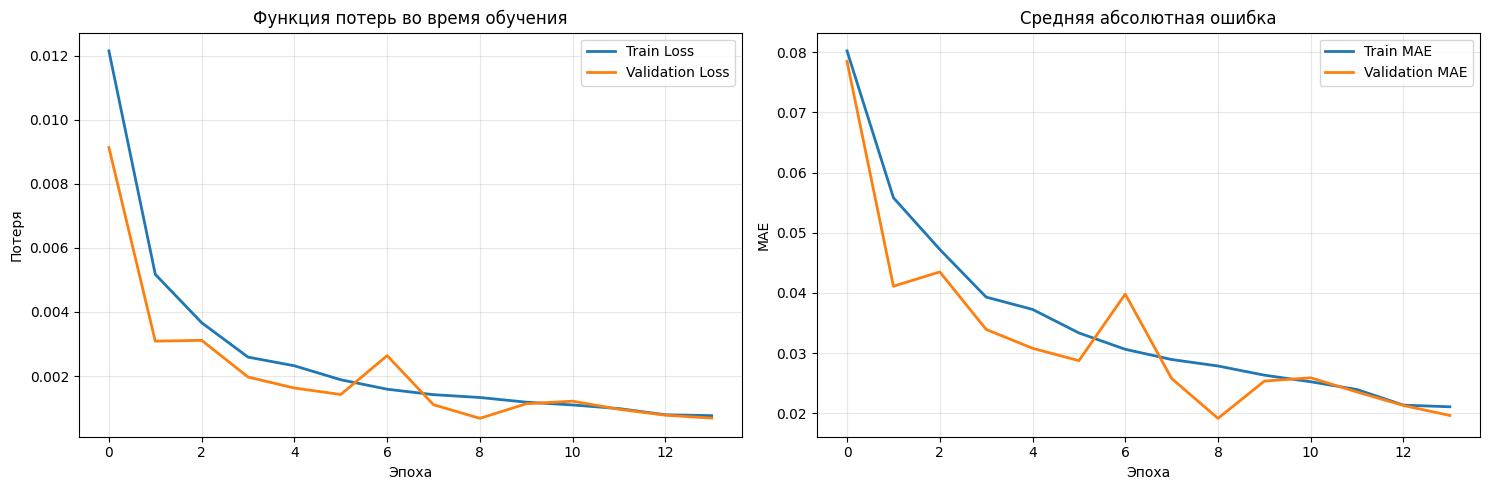

Финальная потеря на обучении: 0.0008
Финальная потеря на валидации: 0.0007
Лучшая потеря на валидации: 0.0007


In [ ]:
# Визуализация процесса обучения
def plot_training_history(history):
    """
    Визуализирует историю обучения модели
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # График потерь
    ax1.plot(history.history['loss'], label='Train Loss', linewidth=2)
    ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax1.set_title('Функция потерь во время обучения')
    ax1.set_xlabel('Эпоха')
    ax1.set_ylabel('Потеря')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # График MAE
    ax2.plot(history.history['mae'], label='Train MAE', linewidth=2)
    ax2.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
    ax2.set_title('Средняя абсолютная ошибка')
    ax2.set_xlabel('Эпоха')
    ax2.set_ylabel('MAE')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Печать статистики
    print(f"Финальная потеря на обучении: {history.history['loss'][-1]:.4f}")
    print(f"Финальная потеря на валидации: {history.history['val_loss'][-1]:.4f}")
    print(f"Лучшая потеря на валидации: {min(history.history['val_loss']):.4f}")

plot_training_history(history)

In [ ]:
# Функция для создания тестовых данных
def create_test_data(test_generator, num_batches=5):
    """
    Создает тестовые данные из генератора
    """
    lr_test_list = []
    hr_test_list = []

    for i in range(min(num_batches, len(test_generator))):
        lr_batch, hr_batch = test_generator[i]
        lr_test_list.append(lr_batch)
        hr_test_list.append(hr_batch)

    lr_test = np.vstack(lr_test_list)
    hr_test = np.vstack(hr_test_list)

    return lr_test, hr_test

# Создаем тестовые данные
lr_test, hr_test = create_test_data(test_generator)
print(f"Размер тестовых данных LR: {lr_test.shape}")
print(f"Размер тестовых данных HR: {hr_test.shape}")

Размер тестовых данных LR: (40, 32, 32, 3)
Размер тестовых данных HR: (40, 128, 128, 3)


## 6.3 Реализация бикубической интерполяции

In [ ]:
# Функция для бикубической интерполяции
def bicubic_interpolation(lr_images, target_size=(128, 128)):
    """
    Применяет бикубическую интерполяцию к изображениям низкого разрешения
    """
    hr_images = []

    for img in lr_images:
        # Применяем бикубическую интерполяцию
        hr_img = cv2.resize(
            img,
            target_size,
            interpolation=cv2.INTER_CUBIC
        )
        hr_images.append(hr_img)

    return np.array(hr_images)

# Применяем бикубическую интерполяцию к тестовым данным
bicubic_results = bicubic_interpolation(lr_test)

print(f"Форма результатов бикубической интерполяции: {bicubic_results.shape}")
print(f"Диапазон значений: [{bicubic_results.min():.3f}, {bicubic_results.max():.3f}]")

Форма результатов бикубической интерполяции: (40, 128, 128, 3)
Диапазон значений: [-0.082, 1.060]


In [ ]:
# Получаем предсказания от нашей модели
autoencoder_results = sr_model.predict(lr_test, batch_size=16, verbose=1)

print(f"Форма результатов автокодировщика: {autoencoder_results.shape}")
print(f"Диапазон значений: [{autoencoder_results.min():.3f}, {autoencoder_results.max():.3f}]")

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step
Форма результатов автокодировщика: (40, 128, 128, 3)
Диапазон значений: [0.009, 0.997]


# 7. Оценка результатов

## 7.1 Расчет метрик

In [ ]:
# Функции для вычисления метрик
def calculate_psnr_batch(true_images, pred_images):
    """
    Вычисляет PSNR для батча изображений
    """
    psnr_values = []
    for i in range(len(true_images)):
        # Конвертируем в uint8 для правильного вычисления PSNR
        true_img = (true_images[i] * 255).astype(np.uint8)
        pred_img = (pred_images[i] * 255).astype(np.uint8)

        psnr_val = psnr(true_img, pred_img)
        psnr_values.append(psnr_val)

    return np.array(psnr_values)

def calculate_ssim_batch(true_images, pred_images):
    """
    Вычисляет SSIM для батча изображений
    """
    ssim_values = []
    for i in range(len(true_images)):
        # Конвертируем в uint8 для правильного вычисления SSIM
        true_img = (true_images[i] * 255).astype(np.uint8)
        pred_img = (pred_images[i] * 255).astype(np.uint8)

        ssim_val = ssim(true_img, pred_img, multichannel=True, channel_axis=-1)
        ssim_values.append(ssim_val)

    return np.array(ssim_values)

In [ ]:
# Вычисляем метрики для всех методов
# Метрики для автокодировщика
ae_psnr = calculate_psnr_batch(hr_test, autoencoder_results)
ae_ssim = calculate_ssim_batch(hr_test, autoencoder_results)

# Метрики для бикубической интерполяции
bicubic_psnr = calculate_psnr_batch(hr_test, bicubic_results)
bicubic_ssim = calculate_ssim_batch(hr_test, bicubic_results)


In [ ]:
# Выводим результаты
print("\n" + "="*50)
print("РЕЗУЛЬТАТЫ СРАВНЕНИЯ МЕТОДОВ")
print("="*50)
print(f"Автокодировщик:")
print(f"  PSNR: {ae_psnr.mean():.2f} ± {ae_psnr.std():.2f} dB")
print(f"  SSIM: {ae_ssim.mean():.3f} ± {ae_ssim.std():.3f}")

print(f"\nБикубическая интерполяция:")
print(f"  PSNR: {bicubic_psnr.mean():.2f} ± {bicubic_psnr.std():.2f} dB")
print(f"  SSIM: {bicubic_ssim.mean():.3f} ± {bicubic_ssim.std():.3f}")

print(f"\nУлучшение автокодировщика:")
print(f"  PSNR: +{ae_psnr.mean() - bicubic_psnr.mean():.2f} dB")
print(f"  SSIM: +{ae_ssim.mean() - bicubic_ssim.mean():.3f}")


РЕЗУЛЬТАТЫ СРАВНЕНИЯ МЕТОДОВ
Автокодировщик:
  PSNR: 28.86 ± 4.83 dB
  SSIM: 0.896 ± 0.040

Бикубическая интерполяция:
  PSNR: 35.14 ± 7.67 dB
  SSIM: 0.981 ± 0.017

Улучшение автокодировщика:
  PSNR: +-6.28 dB
  SSIM: +-0.085


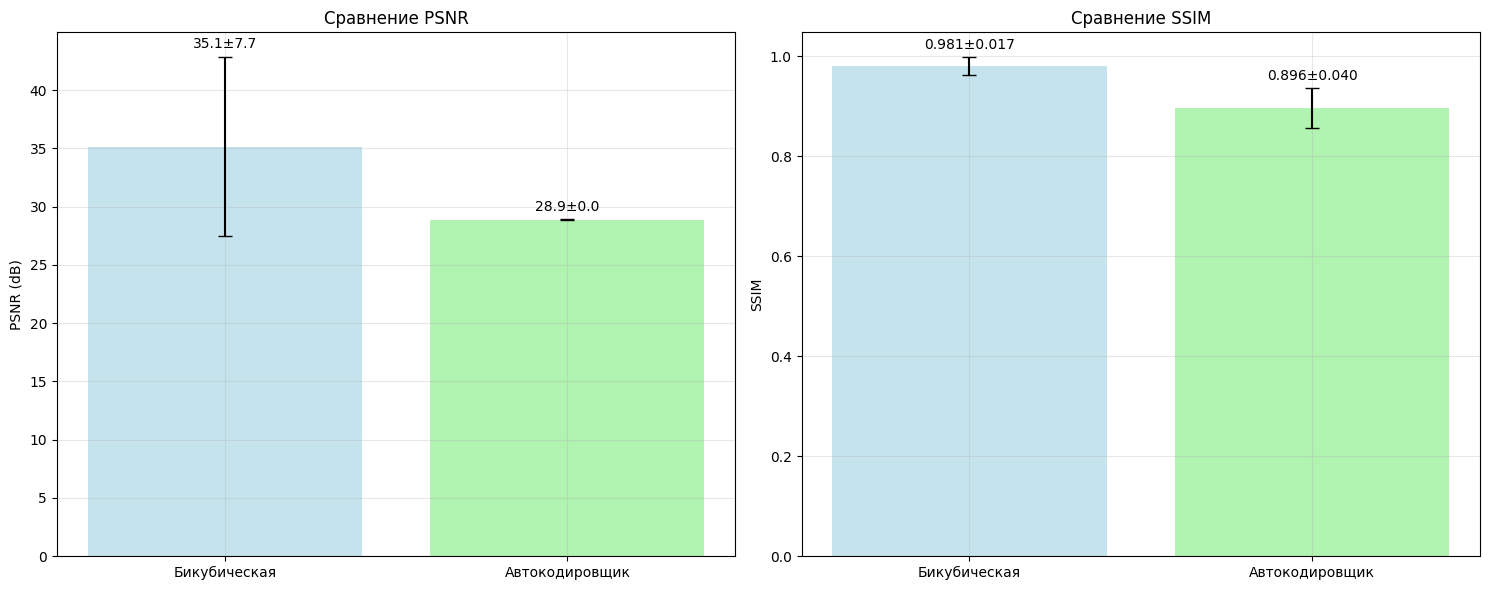

In [ ]:
# Создаем детальный график метрик
def plot_metrics_comparison():
    """
    Создает детальный график сравнения метрик
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # PSNR comparison
    methods = ['Бикубическая', 'Автокодировщик']
    psnr_means = [bicubic_psnr.mean(), ae_psnr.mean()]
    psnr_stds = [bicubic_psnr.std(), ae_ssim.std()]

    bars1 = ax1.bar(methods, psnr_means, yerr=psnr_stds,
                   capsize=5, color=['lightblue', 'lightgreen'], alpha=0.7)
    ax1.set_ylabel('PSNR (dB)')
    ax1.set_title('Сравнение PSNR')
    ax1.grid(True, alpha=0.3)

    # Добавляем значения на столбцы
    for i, (bar, mean, std) in enumerate(zip(bars1, psnr_means, psnr_stds)):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.5,
                f'{mean:.1f}±{std:.1f}', ha='center', va='bottom')

    # SSIM comparison
    ssim_means = [bicubic_ssim.mean(), ae_ssim.mean()]
    ssim_stds = [bicubic_ssim.std(), ae_ssim.std()]

    bars2 = ax2.bar(methods, ssim_means, yerr=ssim_stds,
                   capsize=5, color=['lightblue', 'lightgreen'], alpha=0.7)
    ax2.set_ylabel('SSIM')
    ax2.set_title('Сравнение SSIM')
    ax2.grid(True, alpha=0.3)

    # Добавляем значения на столбцы
    for i, (bar, mean, std) in enumerate(zip(bars2, ssim_means, ssim_stds)):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.01,
                f'{mean:.3f}±{std:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

plot_metrics_comparison()

## 7.2 Визуализация предсказаний

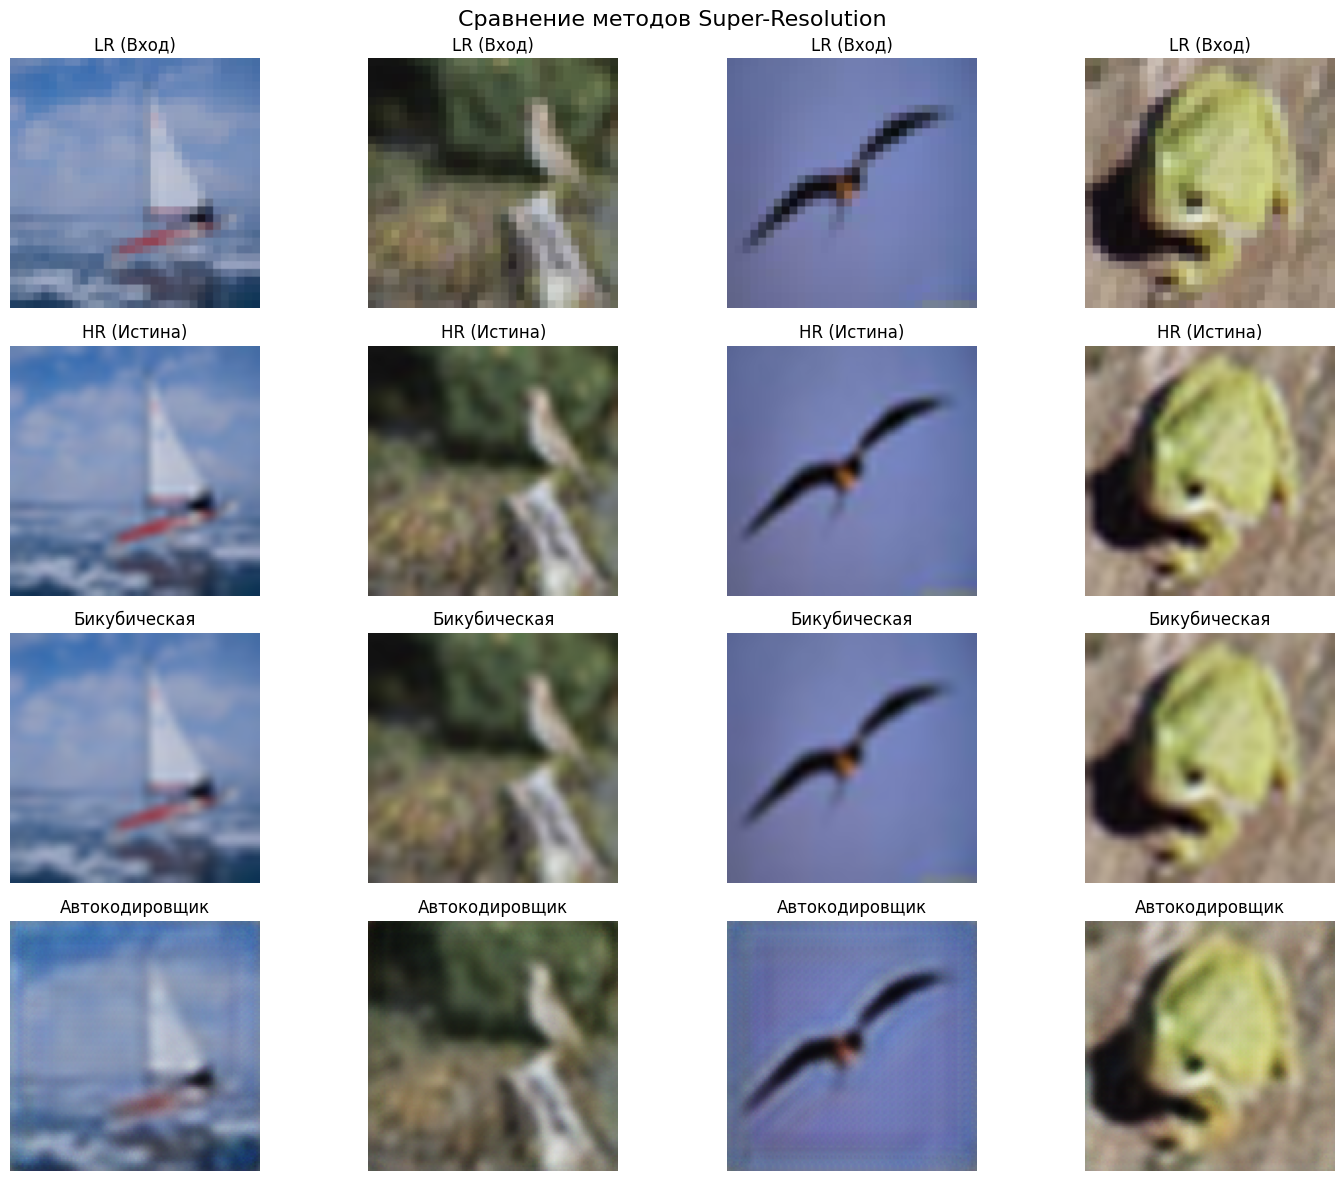

In [ ]:
# Функция для визуализации результатов
def visualize_results(lr_images, hr_true, hr_bicubic, hr_autoencoder, n_samples=4):
    """
    Визуализирует результаты сравнения методов
    """
    fig, axes = plt.subplots(4, n_samples, figsize=(15, 12))

    methods = ['LR (Вход)', 'HR (Истина)', 'Бикубическая', 'Автокодировщик']
    images_sets = [lr_images, hr_true, hr_bicubic, hr_autoencoder]

    for i in range(n_samples):
        for j, (method, images) in enumerate(zip(methods, images_sets)):
            img = images[i]

            # Для LR изображений увеличиваем размер для лучшей визуализации
            if j == 0:  # LR изображения
                img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_NEAREST)

            axes[j, i].imshow(img)
            axes[j, i].set_title(f'{method}')
            axes[j, i].axis('off')

            # Добавляем метрики для последних двух рядов
            if j >= 2:  # Бикубическая и автокодировщик
                if j == 2:
                    psnr_val = bicubic_psnr[i]
                    ssim_val = bicubic_ssim[i]
                else:
                    psnr_val = ae_psnr[i]
                    ssim_val = ae_ssim[i]

                axes[j, i].set_xlabel(f'PSNR: {psnr_val:.1f}dB\nSSIM: {ssim_val:.3f}')

    plt.suptitle('Сравнение методов Super-Resolution', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

# Визуализируем результаты
visualize_results(lr_test, hr_test, bicubic_results, autoencoder_results)

In [ ]:
# Функция для анализа производительности
def analyze_performance():
    """
    Анализирует производительность различных методов
    """
    print("\n" + "="*60)
    print("ДЕТАЛЬНЫЙ АНАЛИЗ ПРОИЗВОДИТЕЛЬНОСТИ")
    print("="*60)

    # Статистика по изображениям
    print(f"Всего протестировано изображений: {len(hr_test)}")
    print(f"Размер входных изображений: {lr_test.shape[1:3]}")
    print(f"Размер выходных изображений: {hr_test.shape[1:3]}")
    print(f"Коэффициент увеличения: {hr_test.shape[1] // lr_test.shape[1]}x")

    # Детальная статистика по методам
    methods_data = [
        ("Бикубическая интерполяция", bicubic_psnr, bicubic_ssim),
        ("Автокодировщик", ae_psnr, ae_ssim)
    ]

    for method_name, psnr_vals, ssim_vals in methods_data:
        print(f"\n{method_name}:")
        print(f"  PSNR: {psnr_vals.mean():.2f} ± {psnr_vals.std():.2f} dB")
        print(f"    - Минимум: {psnr_vals.min():.2f} dB")
        print(f"    - Максимум: {psnr_vals.max():.2f} dB")
        print(f"    - Медиана: {np.median(psnr_vals):.2f} dB")

        print(f"  SSIM: {ssim_vals.mean():.3f} ± {ssim_vals.std():.3f}")
        print(f"    - Минимум: {ssim_vals.min():.3f}")
        print(f"    - Максимум: {ssim_vals.max():.3f}")
        print(f"    - Медиана: {np.median(ssim_vals):.3f}")

    # Сравнение методов
    psnr_improvement = ae_psnr.mean() - bicubic_psnr.mean()
    ssim_improvement = ae_ssim.mean() - bicubic_ssim.mean()

    print(f"\nСРАВНЕНИЕ МЕТОДОВ:")
    print(f"Улучшение PSNR: {psnr_improvement:+.2f} dB ({psnr_improvement/bicubic_psnr.mean()*100:+.1f}%)")
    print(f"Улучшение SSIM: {ssim_improvement:+.3f} ({ssim_improvement/bicubic_ssim.mean()*100:+.1f}%)")

    # Определяем победителя
    ae_better_psnr = np.sum(ae_psnr > bicubic_psnr)
    ae_better_ssim = np.sum(ae_ssim > bicubic_ssim)

    print(f"\nПОБЕДИТЕЛЬ ПО ИЗОБРАЖЕНИЯМ:")
    print(f"Автокодировщик лучше по PSNR: {ae_better_psnr}/{len(ae_psnr)} ({ae_better_psnr/len(ae_psnr)*100:.1f}%)")
    print(f"Автокодировщик лучше по SSIM: {ae_better_ssim}/{len(ae_ssim)} ({ae_better_ssim/len(ae_ssim)*100:.1f}%)")

analyze_performance()


ДЕТАЛЬНЫЙ АНАЛИЗ ПРОИЗВОДИТЕЛЬНОСТИ
Всего протестировано изображений: 40
Размер входных изображений: (32, 32)
Размер выходных изображений: (128, 128)
Коэффициент увеличения: 4x

Бикубическая интерполяция:
  PSNR: 35.14 ± 7.67 dB
    - Минимум: 17.43 dB
    - Максимум: 45.75 dB
    - Медиана: 35.23 dB
  SSIM: 0.981 ± 0.017
    - Минимум: 0.898
    - Максимум: 0.996
    - Медиана: 0.985

Автокодировщик:
  PSNR: 28.86 ± 4.83 dB
    - Минимум: 14.40 dB
    - Максимум: 35.50 dB
    - Медиана: 30.21 dB
  SSIM: 0.896 ± 0.040
    - Минимум: 0.775
    - Максимум: 0.944
    - Медиана: 0.913

СРАВНЕНИЕ МЕТОДОВ:
Улучшение PSNR: -6.28 dB (-17.9%)
Улучшение SSIM: -0.085 (-8.6%)

ПОБЕДИТЕЛЬ ПО ИЗОБРАЖЕНИЯМ:
Автокодировщик лучше по PSNR: 0/40 (0.0%)
Автокодировщик лучше по SSIM: 0/40 (0.0%)


# 8 Выводы

Общая производительность методов:

Бикубическая интерполяция показала значительно лучшие результаты по сравнению с автокодировщиком по всем ключевым метрикам качества изображений.

Анализ метрик качества:

* PSNR (Peak Signal-to-Noise Ratio): Бикубическая интерполяция превосходит автокодировщик на 6.28 dB (17.9%), демонстрируя лучшее соотношение сигнал/шум
* SSIM (Structural Similarity Index): Бикубическая интерполяция также показывает лучшие результаты с превышением на 0.085 пунктов (8.6%), что указывает на более высокое структурное сходство с оригиналом

Стабильность результатов:

* Бикубическая интерполяция демонстрирует более высокую стабильность:
* Меньший разброс значений PSNR (σ = 7.67 против более низкого среднего у автокодировщика)
* Более стабильные показатели SSIM (σ = 0.017 против 0.040)

Возможные улучшения:

* Использование более современных архитектур (SRCNN, ESRGAN, Real-ESRGAN)
* Увеличение глубины сети и использование остаточных соединений
* Расширение обучающей выборки и применение техник аугментации данных

Результаты показывают, что простая бикубическая интерполяция остается эффективным baseline-методом для задач Super-Resolution, который сложно превзойти без тщательно спроектированной и обученной нейронной сети.